In [1]:
from pathlib import Path
import pandas as pd

In [2]:
from ethicml.algorithms.inprocess import GPyT, GPyTDemPar, GPyTEqOdds, LR, SVM, Agarwal, Kamiran, Kamishima, LRCV, ZafarEqOpp
from ethicml.evaluators import evaluate_models, CrossValidator, run_metrics, evaluate_models_parallel
from ethicml.data import Compas, Adult, load_data
from ethicml.metrics import Accuracy, ProbPos, TPR, TNR, AbsCV
from ethicml.preprocessing import train_test_split
from ethicml.visualisation.plot import plot_mean_std_box, single_plot_mean_std_box

In [3]:
# YOU DON'T HAVE TO UNDERSTAND THE CODE IN THIS CELL
# we only tell the model where the "run.py" is and where the python executable is
code_dir = Path('..')
def gp(**kwargs):
    return GPyT(code_dir=code_dir, **kwargs)
def gp_dp(**kwargs):
    return GPyTDemPar(code_dir=code_dir, **kwargs)
def gp_eo(**kwargs):
    return GPyTEqOdds(code_dir=code_dir, **kwargs)

In [4]:
# tnr_race_False = 0.724
# tnr_race_True = 0.702
# tnr_sex_True = 0.724
# tnr_sex_False = 0.744
tnr_in_true_race = 0.71
tnr_in_false_race = 0.74
tnr_in_true_sex = 0.72
tnr_in_false_sex = 0.77

In [5]:
# specify flags for GP
gp_flags = dict(epochs=70, length_scale=1.2, use_loo=False, iso=False, optimizer='RAdam')

In [6]:
algos = []

algos += [gp(s_as_input=True, flags=gp_flags)]
algos += [gp(s_as_input=False, flags=gp_flags)]
# algos += [gp_dp(epochs=70, s_as_input=True)]

for tpr in [0.6,0.7,0.8,0.9]:
    algos += [gp_eo(s_as_input=True, tnr1=tnr_in_true_race, tnr0=tnr_in_true_race, tpr0=tpr, tpr1=tpr, flags=gp_flags)]
    algos += [gp_eo(s_as_input=False, tnr1=tnr_in_false_race, tnr0=tnr_in_false_race, tpr0=tpr, tpr1=tpr, flags=gp_flags)]

baselines = [
    LR(),
    LRCV(),
    SVM(),
    Agarwal(fairness="EqOd"),
    Kamiran(),
#     Kamishima(),
    ZafarEqOpp(),
]
algos += baselines

In [7]:
data = [
    Compas("Race"),
    Compas("Sex"),
#     Adult("Race"),
#     Adult("Sex"),
]

In [8]:
results = evaluate_models_parallel(
    datasets=data,
    inprocess_models=baselines,
    metrics=[Accuracy(), TPR(), TNR()],
    per_sens_metrics=[TPR(), TNR()], 
    repeats=10,
    proportional_splits=True,
    topic="only_baselines",
)

Worker 0 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 1 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 2 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 3 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 4 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 5 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 6 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 7 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 8 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 9 is about to start algo Logistic Regression, C=1.0 on dataset Compas Race - Train.
Worker 10 is about to start algo Logistic Regression, C=1.0 on dataset Compas Sex - Train.

In [9]:
results

Accuracy  \
dataset     transform    model                      repeat              
Compas Race no_transform Logistic Regression, C=1.0 0-0      0.678021   
                         LRCV                       0-0      0.668289   
                         SVM                        0-0      0.688564   
                         Agarwal LR                 0-0      0.671533   
                         Kamiran & Calders LR       0-0      0.676399   
...                                                               ...   
Compas Sex  no_transform LRCV                       9-21690  0.666937   
                         SVM                        9-21690  0.693679   
                         Agarwal LR                 9-21690  0.676661   
                         Kamiran & Calders LR       9-21690  0.673420   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690  0.662075   

                                                                  TNR  \
dataset     transform    model                      repeat              
Compas Race no_transform Logistic Regression, C=1.0 0-0      0.778274   
                         LRCV                       0-0      0.757440   
                         SVM                        0-0      0.797619   
                         Agarwal LR                 0-0      0.769345   
                         Kamiran & Calders LR       0-0      0.778274   
...                                                               ...   
Compas Sex  no_transform LRCV                       9-21690  0.739583   
                         SVM                        9-21690  0.803571   
                         Agarwal LR                 9-21690  0.755952   
                         Kamiran & Calders LR       9-21690  0.751488   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690  0.721726   

                                                             TNR_race_0  \
dataset     transform    model                      repeat                
Compas Race no_transform Logistic Regression, C=1.0 0-0        0.747596   
                         LRCV                       0-0        0.730769   
                         SVM                        0-0        0.752404   
                         Agarwal LR                 0-0        0.733173   
                         Kamiran & Calders LR       0-0        0.745192   
...                                                                 ...   
Compas Sex  no_transform LRCV                       9-21690         NaN   
                         SVM                        9-21690         NaN   
                         Agarwal LR                 9-21690         NaN   
                         Kamiran & Calders LR       9-21690         NaN   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690         NaN   

                                                             TNR_race_0-race_1  \
dataset     transform    model                      repeat                       
Compas Race no_transform Logistic Regression, C=1.0 0-0               0.080529   
                         LRCV                       0-0               0.070012   
                         SVM                        0-0               0.118690   
                         Agarwal LR                 0-0               0.094952   
                         Kamiran & Calders LR       0-0               0.086839   
...                                                                        ...   
Compas Sex  no_transform LRCV                       9-21690                NaN   
                         SVM                        9-21690                NaN   
                         Agarwal LR                 9-21690                NaN   
                         Kamiran & Calders LR       9-21690                NaN   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690                NaN   

                                                             TNR_race_0/race_1  \
dataset     transform    model      

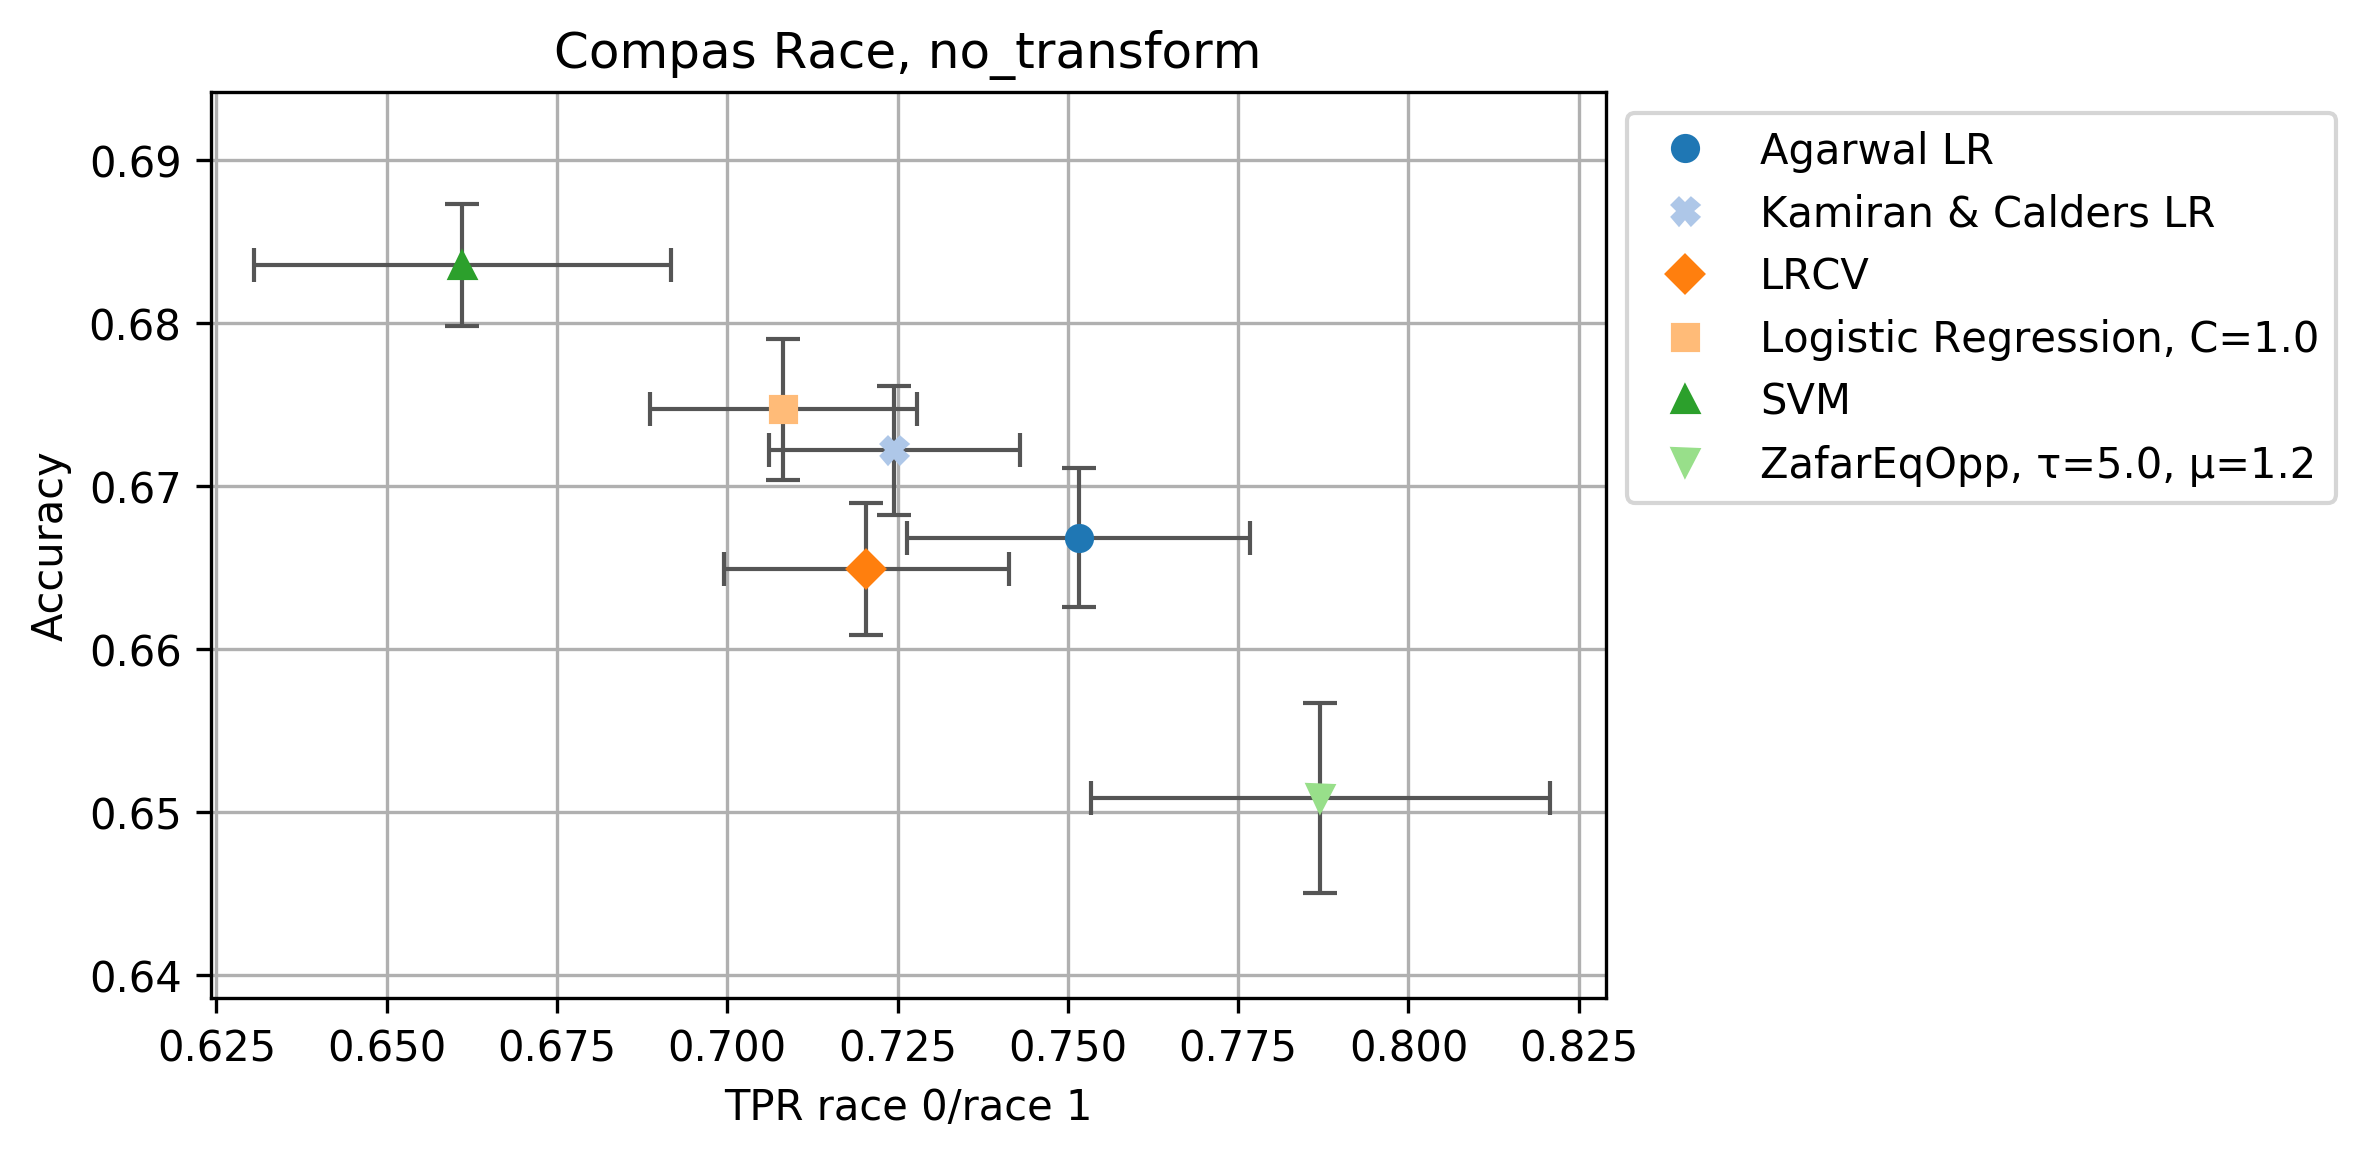

In [10]:
# results = pd.read_csv("results/Compas Race_no_transform.csv").set_index(["dataset", "transform", "model", "repeat"])

plot_mean_std_box(results, "Accuracy", "TPR_race_0/race_1", save=False, use_cross=True)[0][0]

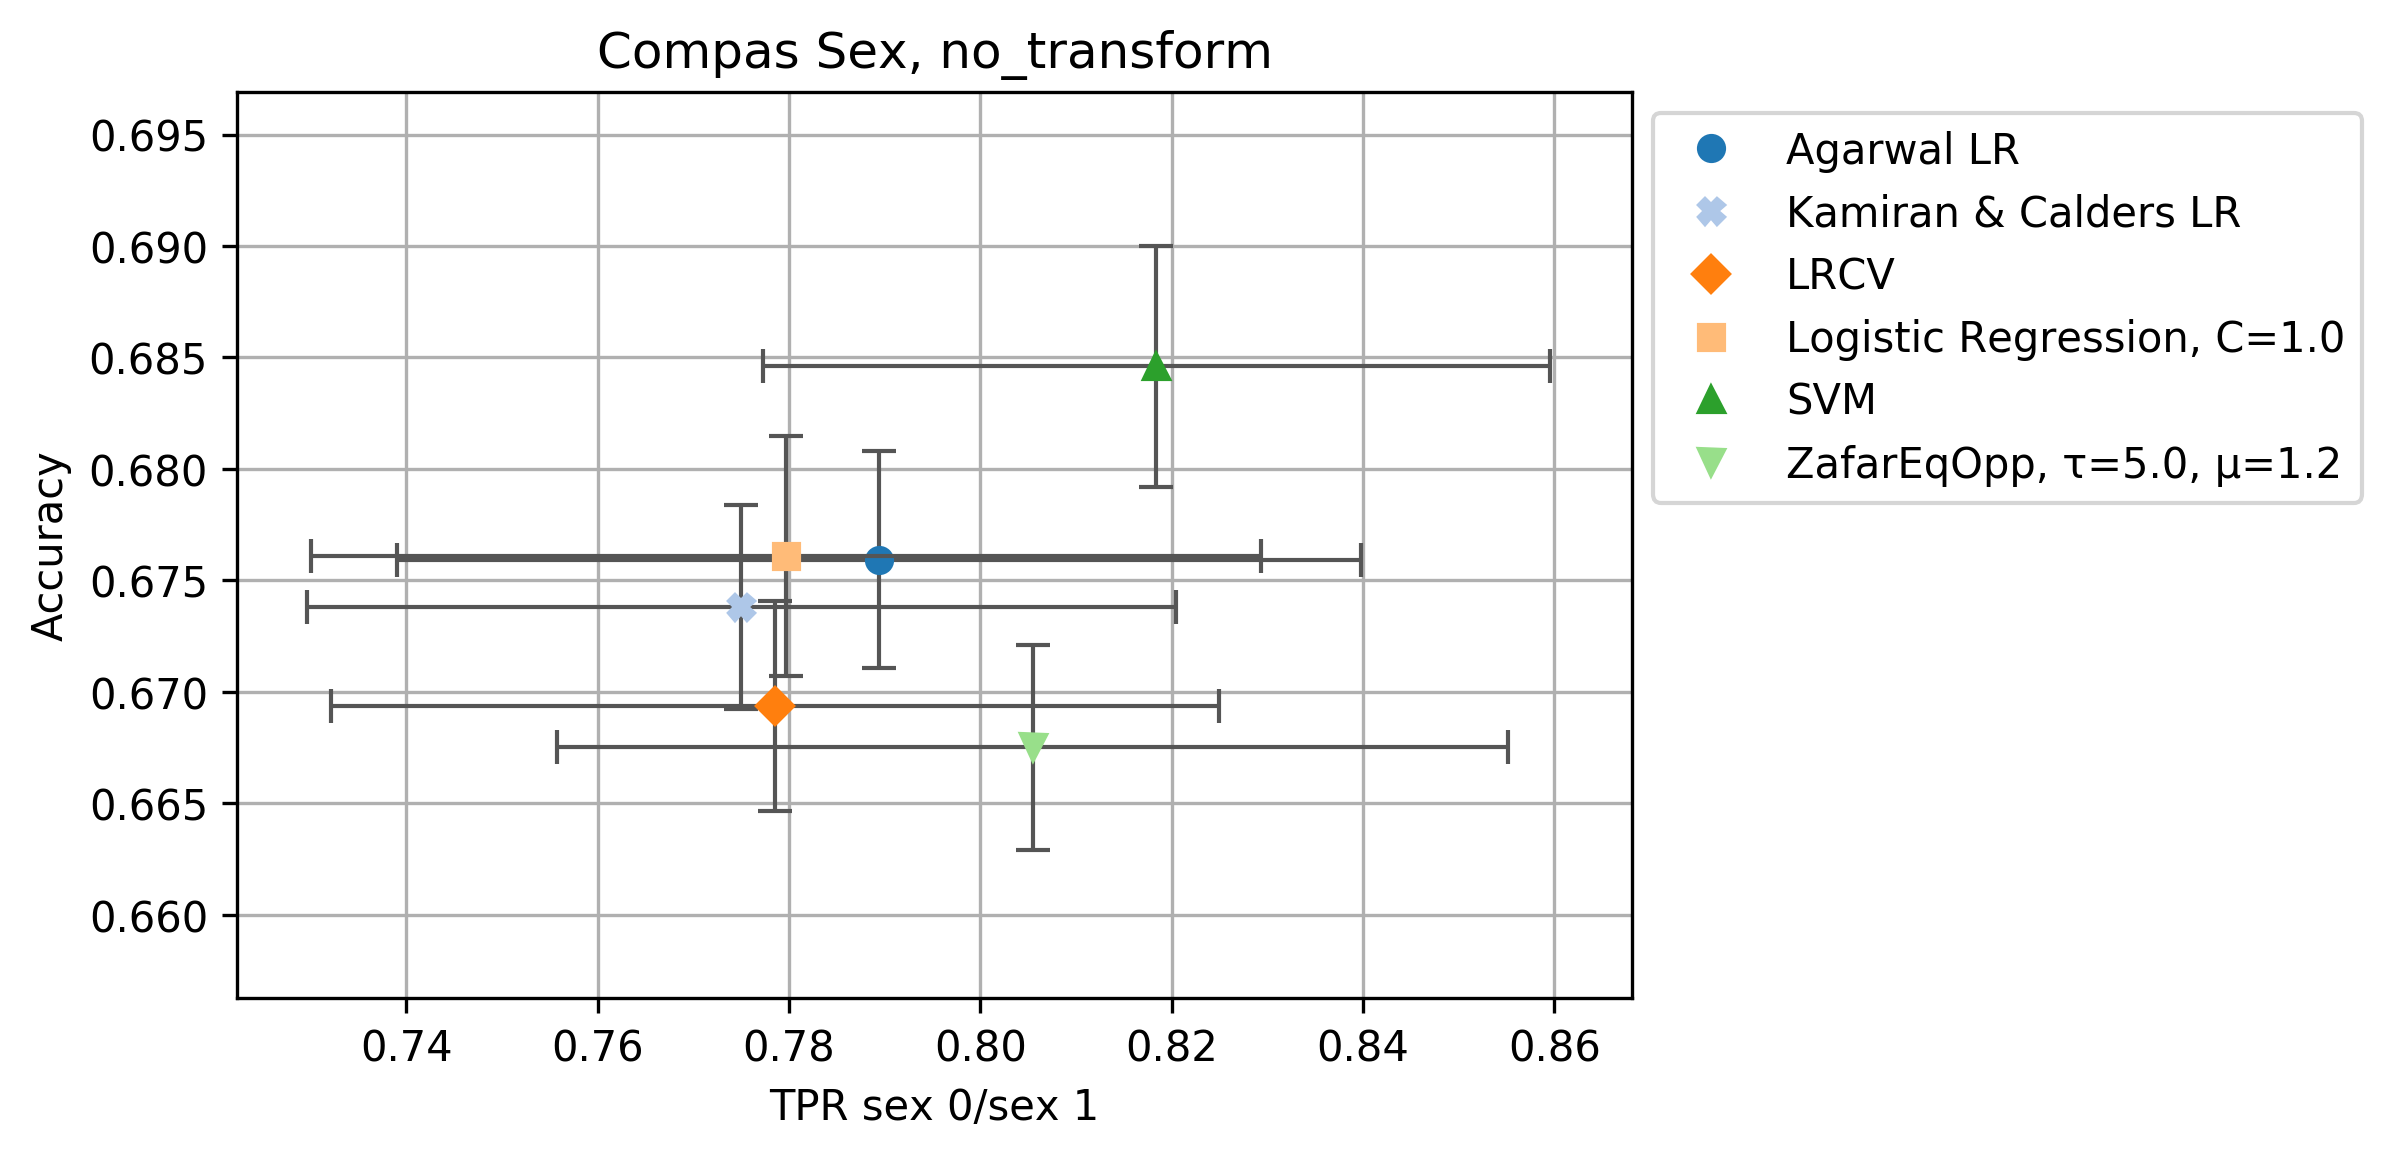

In [11]:
plot_mean_std_box(results, "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]

In [ ]:
plot_mean_std_box(results.query('~model.str.contains("True")'), "Accuracy", "TPR_race_0/race_1", save=False, use_cross=True)[0][0]

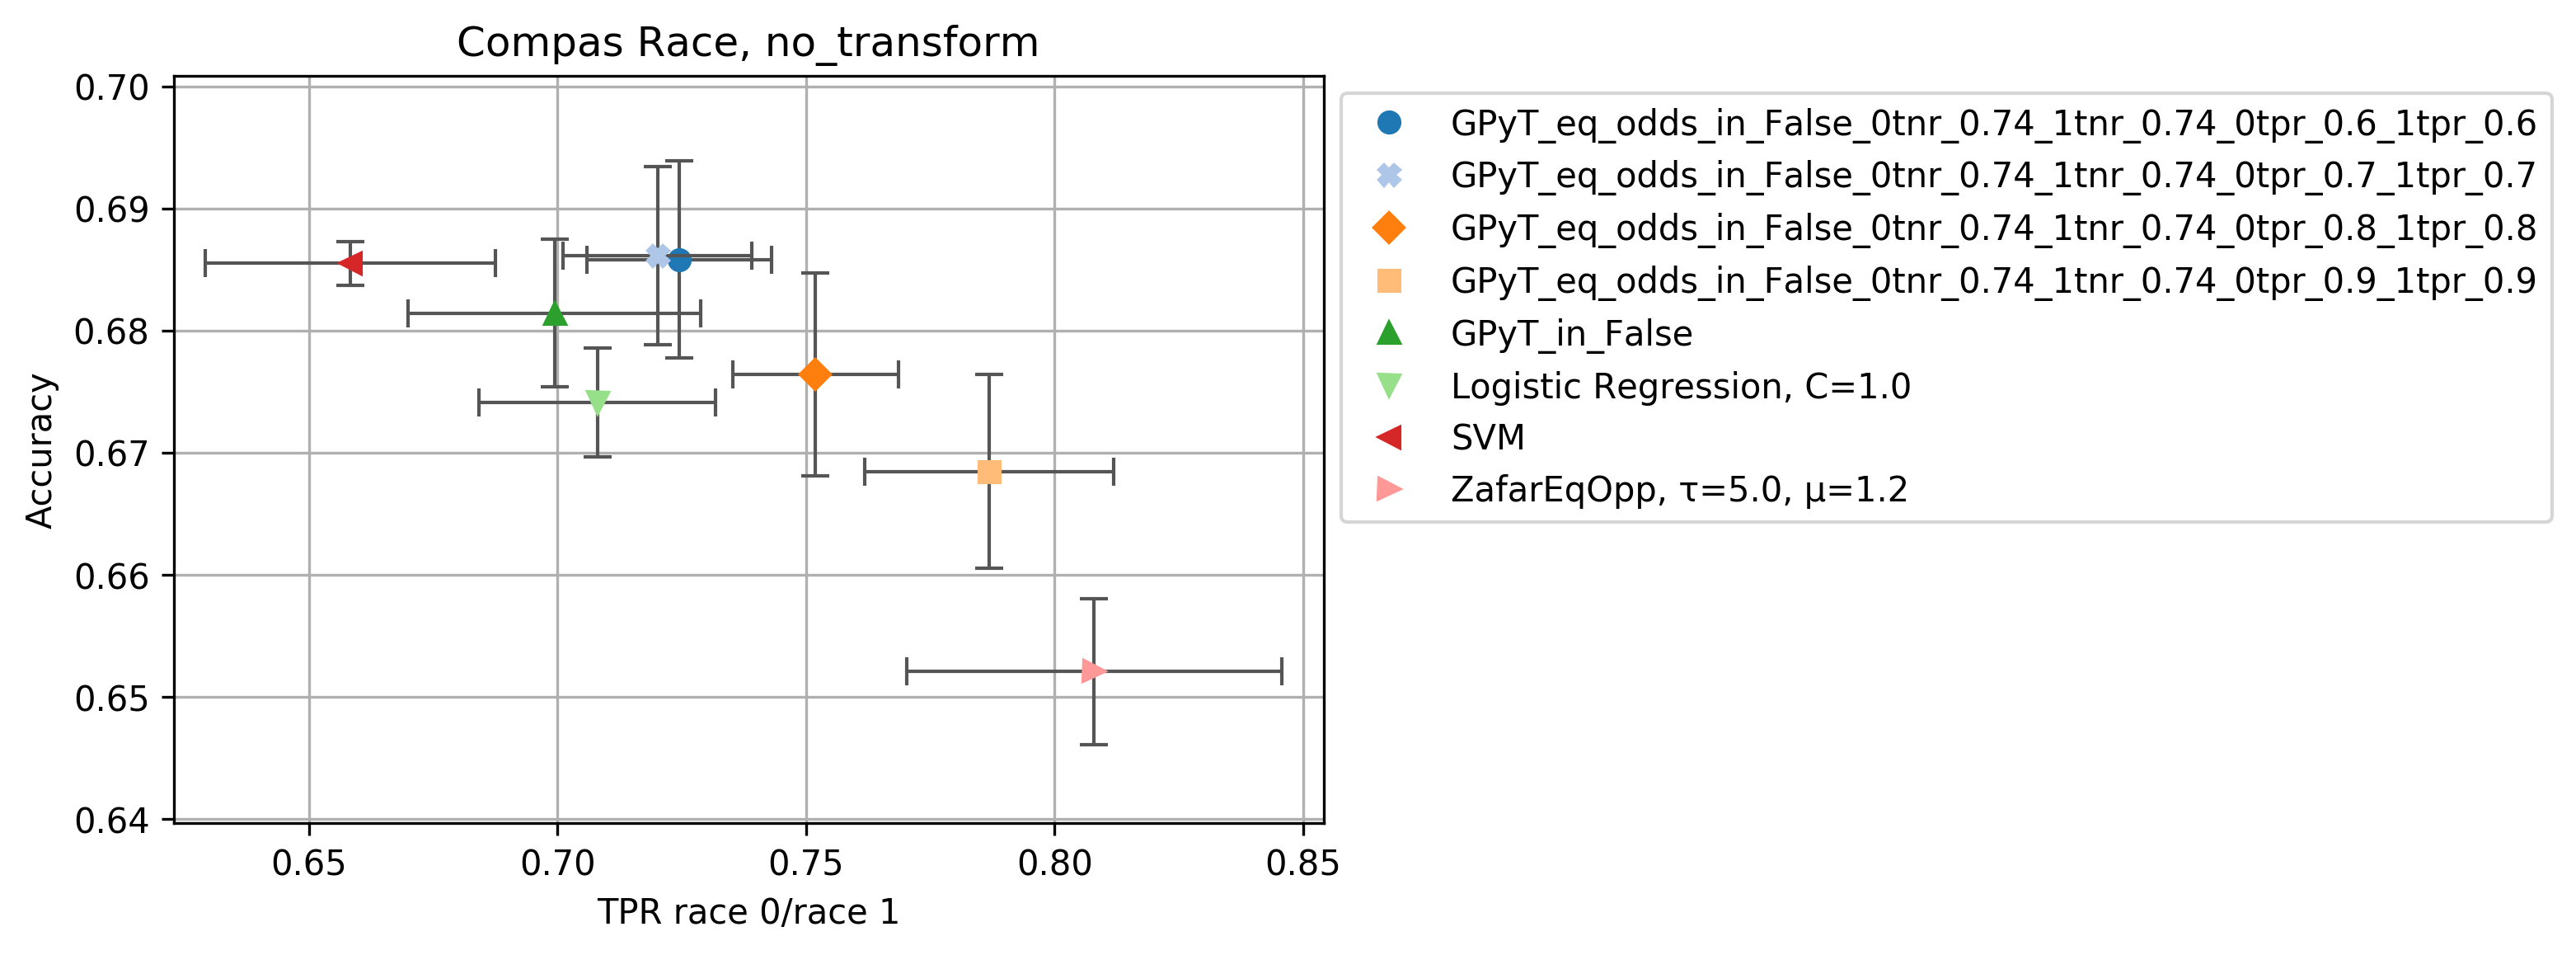

In [56]:
plot_mean_std_box(results.query('~model.str.contains("True")'), "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]